In [93]:
import os
import glob
import pickle

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import lightning as L

from src.utils import SEED

In [ ]:
# ORIGIN_DIR = "data/origin"
# PKL_DIR = "data/pkl"

# os.makedirs(PKL_DIR, exist_ok=True)

# xlsx_files = glob.glob(os.path.join(ORIGIN_DIR, "*.xlsx"))

# for xlsx_path in xlsx_files:
#     filename = os.path.splitext(os.path.basename(xlsx_path))[0]
#     pkl_path = os.path.join(PKL_DIR, f"{filename}.pkl")

#     # xlsx → pandas DataFrame
#     df = pd.read_excel(xlsx_path)

#     # pandas DataFrame 그대로 pkl 저장
#     with open(pkl_path, "wb") as f:
#         pickle.dump(df, f)

#     print(f"[OK] {filename}.xlsx → {filename}.pkl")

# print("모든 파일 변환 완료")


In [57]:
df = {}

for path in glob.glob("data/pkl/*.pkl"):
    filename = os.path.splitext(os.path.basename(path))[0]
    gas, data_type = filename.split("_", 1)

    if gas not in df:
        df[gas] = {}

    with open(path, "rb") as f:
        obj = pickle.load(f)

    df[gas][data_type] = obj


In [58]:
print(df.keys())
print('acetone shapes:')
print(df['acetone']['merge'].shape)
print(df['acetone']['merge_reflection'].shape)
print(df['acetone']['ex_25%'].shape)
print('benzene shapes:')
print(df['benzene']['merge'].shape)
print(df['benzene']['merge_reflection'].shape)
print(df['benzene']['ex_25%'].shape)
print('toluene shapes:')
print(df['toluene']['merge'].shape)
print(df['toluene']['merge_reflection'].shape)
print(df['toluene']['ex_25%'].shape)

dict_keys(['acetone', 'benzene', 'toluene'])
acetone shapes:
(7300, 5623)
(10001, 5623)
(5622, 4)
benzene shapes:
(7300, 5678)
(10000, 5678)
(5677, 4)
toluene shapes:
(7300, 5338)
(10000, 5338)
(5337, 4)


In [38]:
mr = df['acetone']['merge_reflection']
ex = df['acetone']['ex_25%']

k = 0

delay = mr.iloc[:, 0].to_numpy()
spectrum = mr.iloc[:, k + 1].to_numpy()

A_max = spectrum.max()
threshold = A_max * 10 ** (-6 / 20)   # ≈ 0.501 * A_max

In [40]:
valid_idx = np.where(spectrum >= threshold)[0]

idx_low = valid_idx[0]
idx_high = valid_idx[-1]

center_delay = (delay[idx_low] + delay[idx_high]) / 2

# pandas 방식으로 컬럼 접근
center_shift_ex = ex["Center shift (s)"].to_numpy()[k]

print(f"[Time index {k}]")
print(f"Computed center delay (6 dB): {center_delay:.6e} s")
print(f"Recorded center shift (ex_25%): {center_shift_ex:.6e} s")
print(f"Difference: {(center_delay - center_shift_ex):.3e} s")


[Time index 0]
Computed center delay (6 dB): -8.556000e-05 s
Recorded center shift (ex_25%): -8.754000e-05 s
Difference: 1.980e-06 s


In [23]:
gas_to_label = {
    "acetone": 0,
    "benzene": 1,
    "toluene": 2,
}
samples = []
labels = []

for gas, label in gas_to_label.items():
    merge = df[gas]["merge"].to_numpy()
    time = merge[:, 0]
    signal = merge[:, 1:]

    for i in range(signal.shape[1]):
        samples.append(signal[:, i].astype(np.float32))
        labels.append(label)

print(samples[:3])

[array([0.00421053, 0.00842105, 0.00842105, ..., 0.00761905, 0.00761905,
       0.00761905], shape=(7300,), dtype=float32), array([0.00842105, 0.00842105, 0.00842105, ..., 0.00761905, 0.00380952,
       0.00761905], shape=(7300,), dtype=float32), array([0.00842105, 0.00842105, 0.00842105, ..., 0.00761905, 0.00761905,
       0.00761905], shape=(7300,), dtype=float32)]


In [ ]:
# import os
# import pandas as pd

# folder_path = input("폴더를 선택해라 : ")
# file_name = input("파일 이름 말해 : ")
# excel_file_path = os.path.join(folder_path, f"{file_name}.xlsx")

# # 엑셀 파일 읽기
# df = pd.read_excel(excel_file_path)

# target_percentage = 0.25
# average_values = []

# for col in df.columns[1:]:
#     column_values = df[col][1:]
#     max_value = column_values.max()
#     max_value_row = column_values.idxmax()

#     target_value = max_value * target_percentage

#     # max_value_row 이전과 이후에서 target_value에 가장 가까운 값 찾기
#     diff_before = (column_values[:max_value_row] - target_value).abs()
#     diff_after = (column_values[max_value_row + 1:] - target_value).abs()

#     closest_before_idx = diff_before.idxmin() if not diff_before.empty else None
#     closest_after_idx = diff_after.idxmin() if not diff_after.empty else None

#     # 1열 값 가져오기
#     if closest_before_idx is not None:
#         closest_before = df.at[closest_before_idx, 'Time']
#     else:
#         closest_before = None

#     if closest_after_idx is not None: 
#         closest_after = df.at[closest_after_idx, 'Time']
#     else:
#         closest_after = None

#     # 중간 값 계산
#     if closest_before is not None and closest_after is not None:
#         average_value = (closest_before + closest_after) / 2
#     else:
#         average_value = None

#     average_values.append(average_value)

# # 결과 저장
# new_df = pd.DataFrame({'Time': df.columns[1:], '1열 값': average_values})

# new_file_name = input("분석 파일 이름 정해라: ")
# new_excel_file_path = os.path.join(folder_path, f"{new_file_name}.xlsx")
# new_df.to_excel(new_excel_file_path, index=False)

# print(f"새로운 엑셀 파일이 저장 완.")


In [53]:
import numpy as np
import pandas as pd


def compute_center_shift_from_column(
    time: np.ndarray,
    signal: np.ndarray,
    target_percentage: float = 0.25
) -> float:
    """
    merge 데이터의 단일 열(signal)로부터 center_shift 값을 계산

    Parameters
    ----------
    time : np.ndarray
        Time 축 (shape: T,)
    signal : np.ndarray
        하나의 merge 열 (shape: T,)
    target_percentage : float
        최대값 대비 비율 (default=0.25)

    Returns
    -------
    center_shift : float
    """

    # 원 코드와 동일: 첫 row 제외
    signal_values = signal[1:]
    time_values = time[1:]

    max_idx = np.argmax(signal_values)
    max_value = signal_values[max_idx]

    target_value = max_value * target_percentage

    # 최대값 이전 / 이후
    before = signal_values[:max_idx]
    after = signal_values[max_idx + 1:]

    before_time = time_values[:max_idx]
    after_time = time_values[max_idx + 1:]

    center_before = np.nan
    center_after = np.nan

    if before.size > 0:
        idx = np.argmin(np.abs(before - target_value))
        center_before = before_time[idx]

    if after.size > 0:
        idx = np.argmin(np.abs(after - target_value))
        center_after = after_time[idx]

    if not np.isnan(center_before) and not np.isnan(center_after):
        return (center_before + center_after) / 2

    return np.nan


In [54]:
def compute_center_shift_from_merge(
    merge_df: pd.DataFrame,
    time_col: str = "Time",
    target_percentage: float = 0.25
) -> np.ndarray:
    """
    merge 데이터 전체 열에 대해 center_shift 계산

    Returns
    -------
    center_shifts : np.ndarray (shape: N,)
    """

    time = merge_df[time_col].to_numpy()
    center_shifts = []

    for col in merge_df.columns:
        if col == time_col:
            continue

        signal = merge_df[col].to_numpy()
        cs = compute_center_shift_from_column(
            time,
            signal,
            target_percentage
        )
        center_shifts.append(cs)

    return np.array(center_shifts)


In [61]:
print(df['acetone']['ex_25%'][2])

KeyError: 2

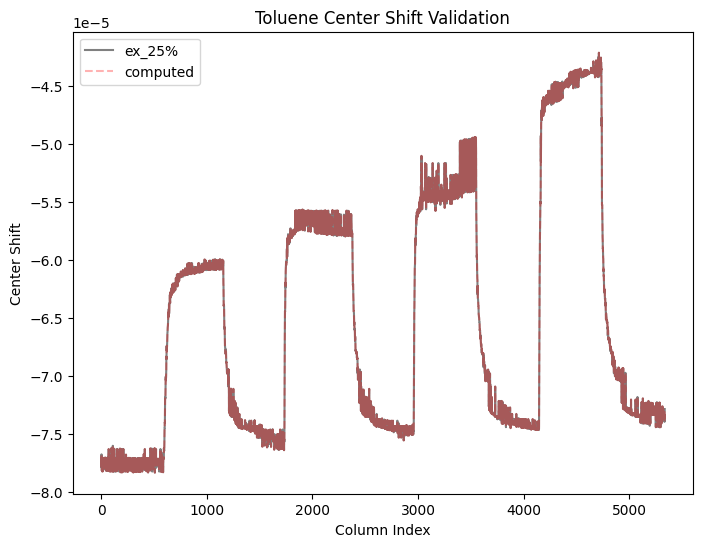

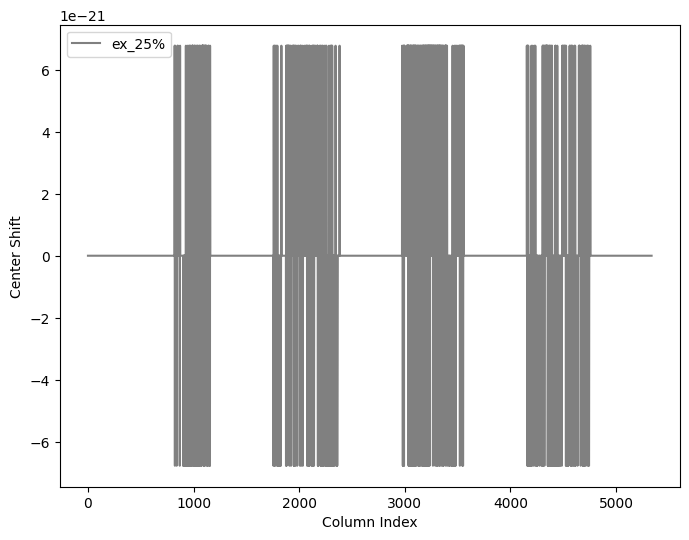

6.776263578034403e-21 -6.776263578034403e-21


In [79]:
import matplotlib.pyplot as plt

# 내가 계산한 center_shift
computed_center_shift = compute_center_shift_from_merge(df['toluene']['merge'])

# 기존 ex_25% 데이터의 3열
reference_center_shift = df['toluene']['ex_25%'].iloc[:, 2].to_numpy()

# 1:1 비교
plt.figure(figsize=(8, 6))
plt.plot(reference_center_shift, color='gray', label="ex_25%")
plt.plot(computed_center_shift, "--", color='red', alpha=0.3, label="computed")
plt.xlabel("Column Index")
plt.ylabel("Center Shift")
plt.legend()
plt.title("Toluene Center Shift Validation")

value_diff = reference_center_shift-computed_center_shift
plt.figure(figsize=(8, 6))
plt.plot(value_diff, color='gray', label="ex_25%")
plt.xlabel("Column Index")
plt.ylabel("Center Shift")
plt.legend()
plt.show()

print(max(value_diff), min(value_diff))

In [52]:
def extract_ex_percentage(
    df: pd.DataFrame,
    target_percentage: float = 0.25,
    time_col: str = "Time"
) -> pd.DataFrame:
    results = []

    for col in df.columns:
        if col == time_col:
            continue

        column_values = df[col].iloc[1:]  # 원 코드와 동일
        max_value = column_values.max()
        max_value_row = column_values.idxmax()

        target_value = max_value * target_percentage

        # 최대값 이전 / 이후에서 target_value에 가장 가까운 값
        diff_before = (column_values.loc[:max_value_row] - target_value).abs()
        diff_after = (column_values.loc[max_value_row + 1:] - target_value).abs()

        closest_before_idx = diff_before.idxmin() if not diff_before.empty else None
        closest_after_idx = diff_after.idxmin() if not diff_after.empty else None

        before_time = (
            df.at[closest_before_idx, time_col]
            if closest_before_idx is not None else np.nan
        )

        after_time = (
            df.at[closest_after_idx, time_col]
            if closest_after_idx is not None else np.nan
        )

        if not np.isnan(before_time) and not np.isnan(after_time):
            average_time = (before_time + after_time) / 2
        else:
            average_time = np.nan

        results.append([
            col,
            before_time,
            after_time,
            average_time
        ])

    result_df = pd.DataFrame(
        results,
        columns=["Column", "Before_Time", "After_Time", "Average_Time"]
    )

    return result_df

<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ty\AppData\Local\Temp\ipykernel_102412\1652629260.py:66: SyntaxWarning: invalid escape sequence '\m'
  ckpt_path = 'checkpoint\mlp-epoch=105-val_loss=0.01.ckpt'
Seed set to 36


x shape (16636, 7300)
y shape (16636,)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


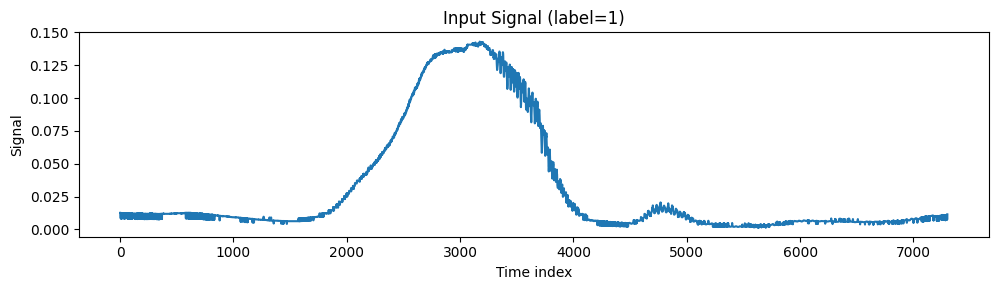

=== Classification Result ===
GT label   : 1 (benzene)
Pred label : 1 (benzene)
Probabilities:
  acetone : 0.0015
  benzene : 0.9985
  toluene : 0.0000


In [97]:
from src.model import create_model
from src.dataset import GasDataModule
from main import GasClsModel

L.seed_everything(SEED)

def build_samples(df: dict, gas_to_label: dict):
    samples = []
    labels = []

    for gas, label in gas_to_label.items():
        merge = df[gas]["merge"].to_numpy()
        time = merge[:, 0]
        signal = merge[:, 1:]

        for i in range(signal.shape[1]):
            samples.append(signal[:, i].astype(np.float32))
            labels.append(label)

    x = np.stack(samples)
    y = np.array(labels)

    print("x shape", x.shape)
    print("y shape", y.shape)
    return x, y

gas_to_label = {
    "acetone": 0,
    "benzene": 1,
    "toluene": 2,
}

df = {}
for path in glob.glob("data/pkl/*.pkl"):
    filename = os.path.splitext(os.path.basename(path))[0]
    gas, data_type = filename.split("_", 1)

    if gas not in df:
        df[gas] = {}

    with open(path, "rb") as f:
        obj = pickle.load(f)

    df[gas][data_type] = obj
X, y = build_samples(df, gas_to_label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y,
)

train_data = (X_train, y_train)
test_data = (X_test, y_test)

trainer = L.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=300,
    # logger=wandb_logger,
    # callbacks=[checkpoint_callback, early_stopping],
)

model_name = 'mlp'
ckpt_path = 'checkpoint\mlp-epoch=105-val_loss=0.01.ckpt'

model = GasClsModel.load_from_checkpoint(
    ckpt_path,
    model=create_model(
        model=model_name,
        input_length=7300,
        num_classes=3,
    ),
    num_classes=3,
)


idx = 500  # 보고 싶은 샘플 인덱스
x_sample = test_data[0][idx]        # (7300,)
y_true = test_data[1][idx]

plt.figure(figsize=(10, 3))
plt.plot(x_sample)
plt.title(f"Input Signal (label={y_true})")
plt.xlabel("Time index")
plt.ylabel("Signal")
plt.tight_layout()
plt.show()

model.eval()

with torch.no_grad():
    x_tensor = torch.from_numpy(x_sample).unsqueeze(0).to(model.device)
    logits = model(x_tensor)
    probs = torch.softmax(logits, dim=1)

pred_class = probs.argmax(dim=1).item()

label_to_gas = {v: k for k, v in gas_to_label.items()}

print("=== Classification Result ===")
print(f"GT label   : {y_true} ({label_to_gas[y_true]})")
print(f"Pred label : {pred_class} ({label_to_gas[pred_class]})")
print("Probabilities:")
for i, p in enumerate(probs.squeeze().cpu().numpy()):
    print(f"  {label_to_gas[i]:8s}: {p:.4f}")

In [102]:
a = 100
b = a*0.8
c = a*0.2
d = b*0.8
e = b*0.2

print(d, e, c)

64.0 16.0 20.0
